In [27]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
from keras import layers, models, optimizers
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
class DQN(models.Model):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(action_space, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        q_values = self.output_layer(x)
        return q_values

In [29]:
class DQNAgent:
    def __init__(self, action_space):
        self.action_space = action_space 
        self.memory = deque(maxlen=10000)
        self.gamma = 0.9  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(self.action_space)
        self.target_model = DQN(self.action_space)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = optimizers.Adam(learning_rate=0.01)
        self.loss_function = tf.keras.losses.Huber()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > 10000:
            del self.memory[0]

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch_experience = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch_experience:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.target_model.predict(state)
            target_f[0][action] = target
            with tf.GradientTape() as tape:
                q_values = self.model(state)
                loss = self.loss_function(target_f, q_values)
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [30]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array")
action_space = env.action_space.n
state_space = env.observation_space.n
agent = DQNAgent(action_space)

In [31]:
batch_size = 100  # Decreased batch size
num_episodes = 10  # Increased number of episodes
max_steps = 100  # Increased maximum steps per episode
update_target_frequency = 1  # Decreased update frequency

In [49]:
def render(env):
    plt.clf()
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

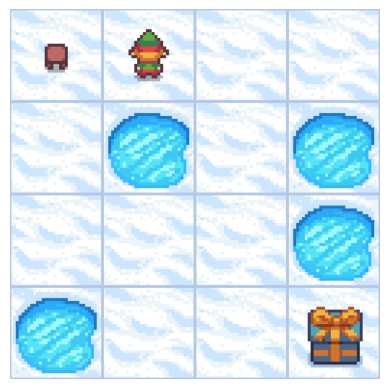

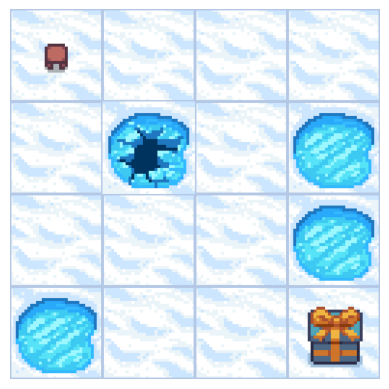

Episode: 0 Total Reward: -0.02
1/1 [==============================] - 0s 10ms/step
Episode: 0 Total Reward: -0.02


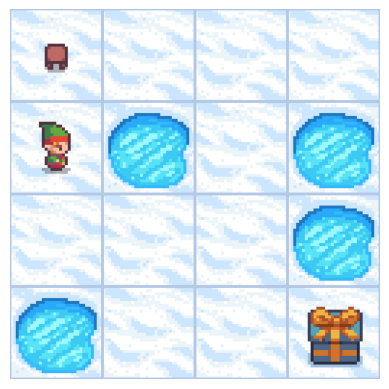

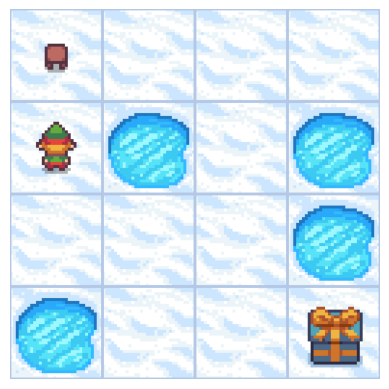

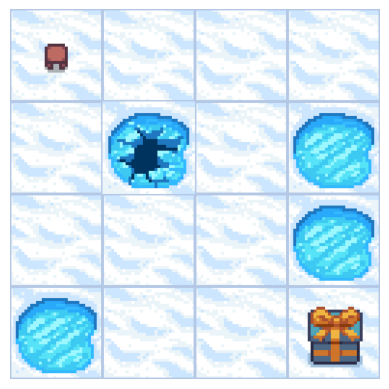

Episode: 1 Total Reward: -0.03
1/1 [==============================] - 0s 10ms/step


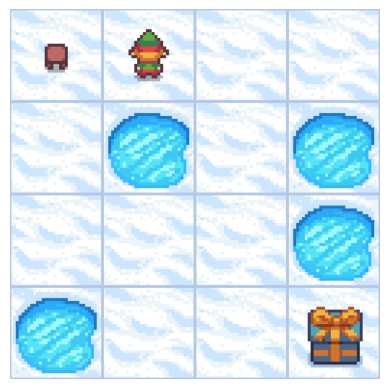

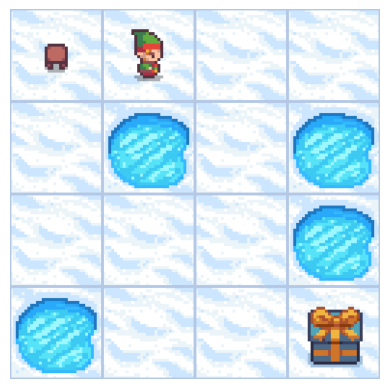

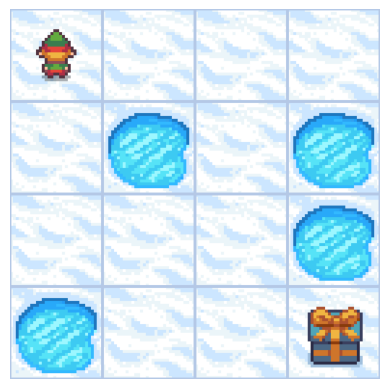

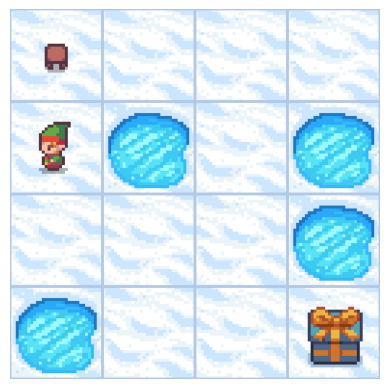

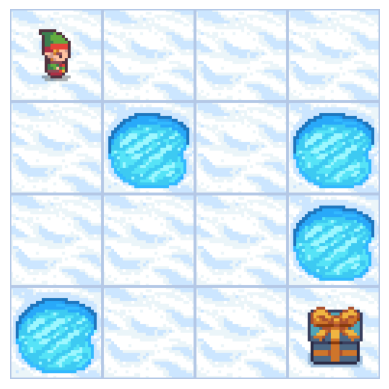

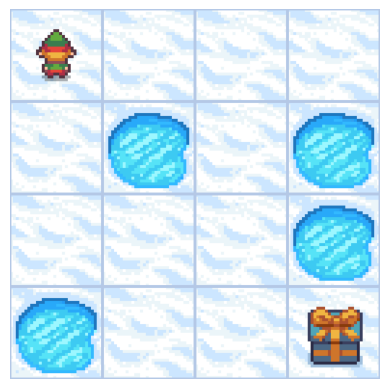

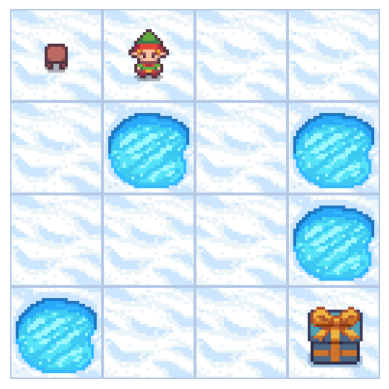

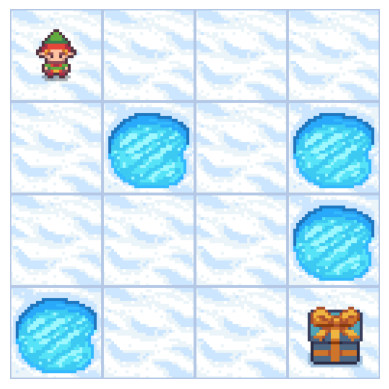

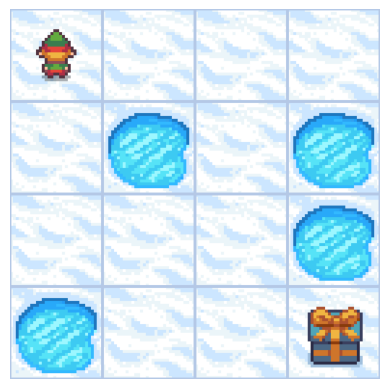

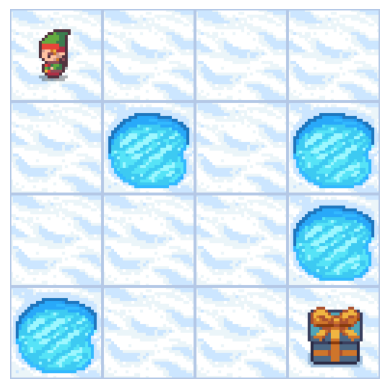

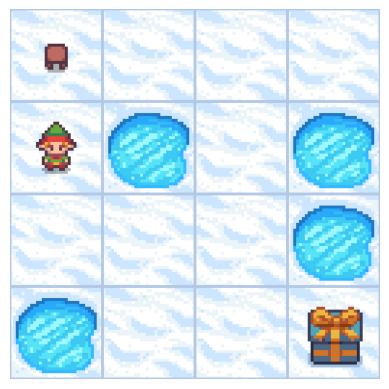

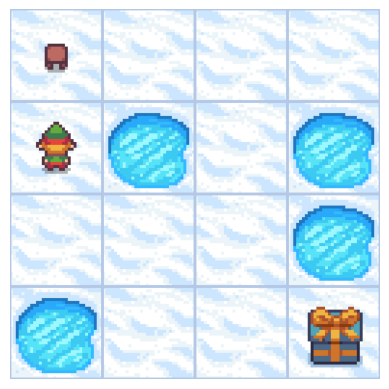

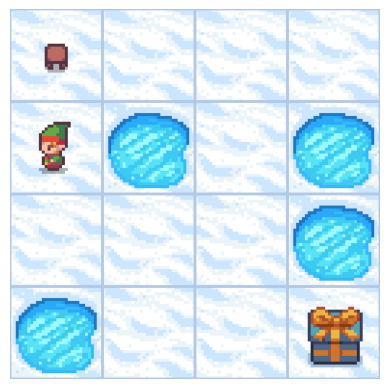

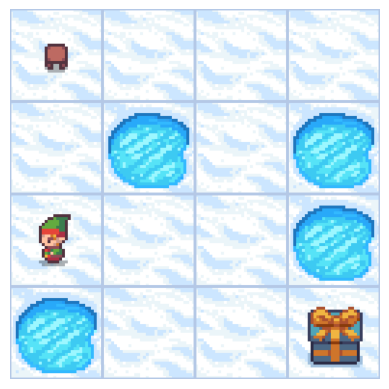

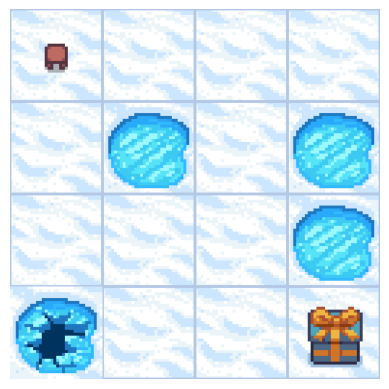

Episode: 2 Total Reward: -0.15
1/1 [==============================] - 0s 10ms/step


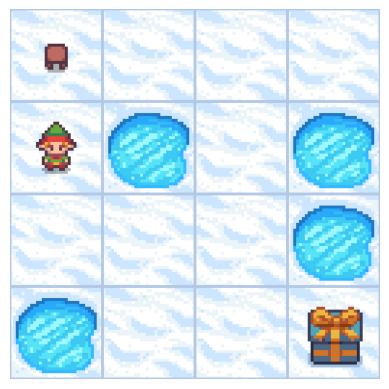

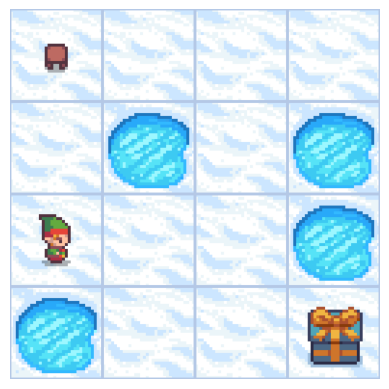

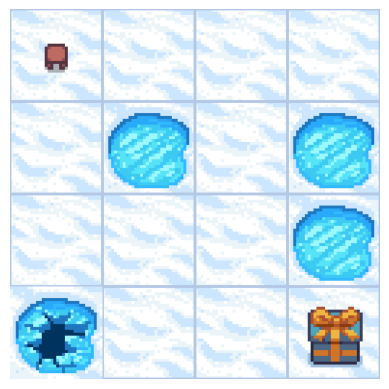

Episode: 3 Total Reward: -0.03
1/1 [==============================] - 0s 10ms/step


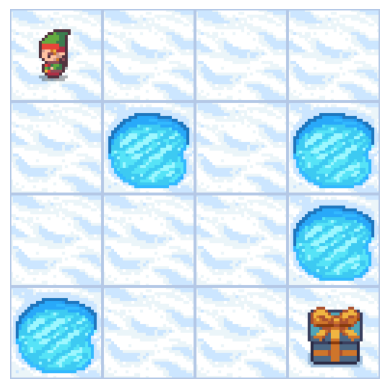

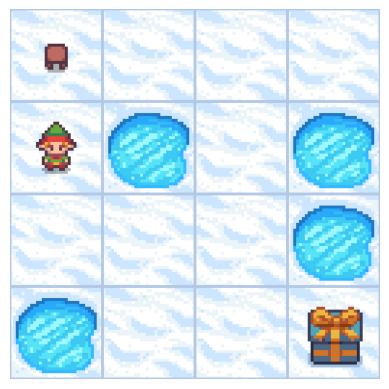

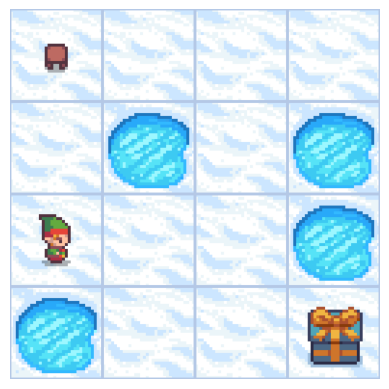

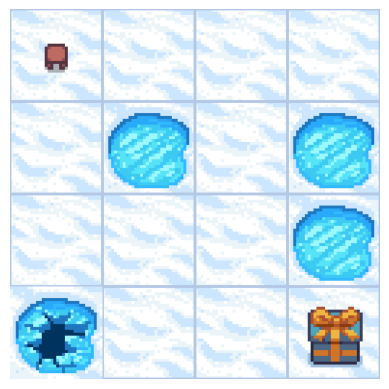

Episode: 4 Total Reward: -0.04
1/1 [==============================] - 0s 10ms/step


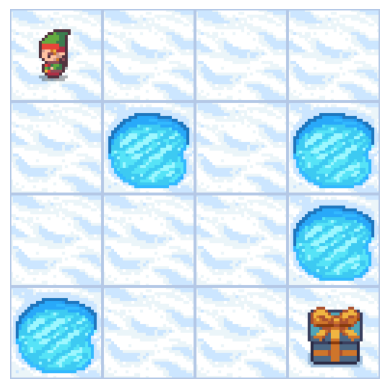

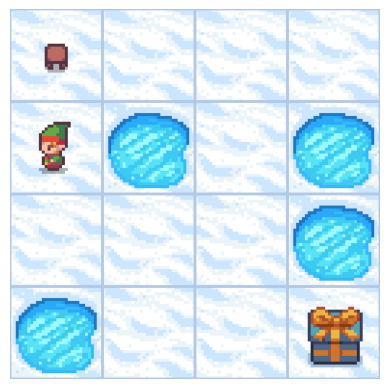

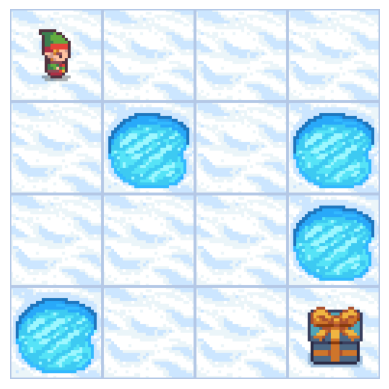

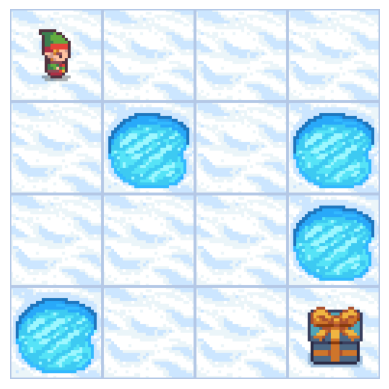

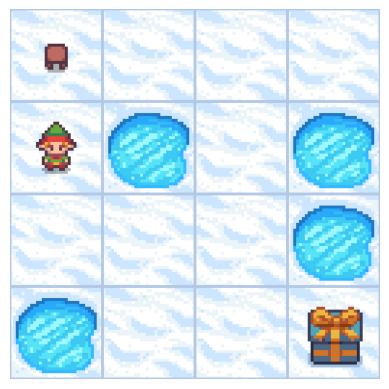

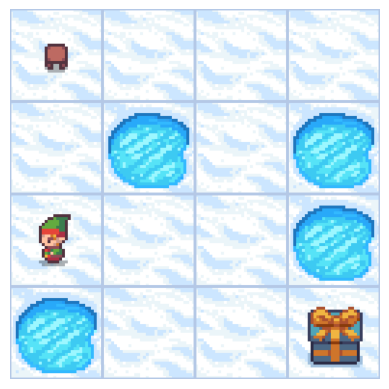

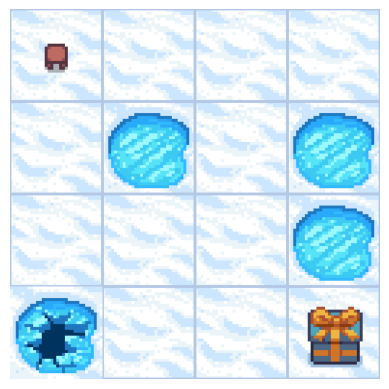

Episode: 5 Total Reward: -0.07
1/1 [==============================] - 0s 10ms/step


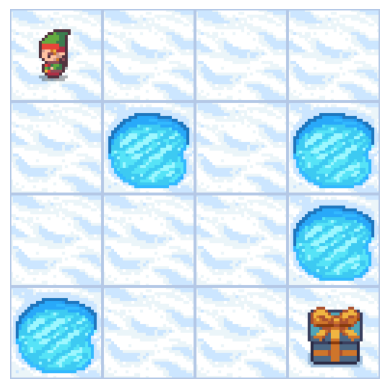

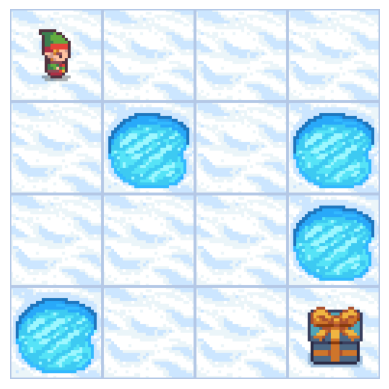

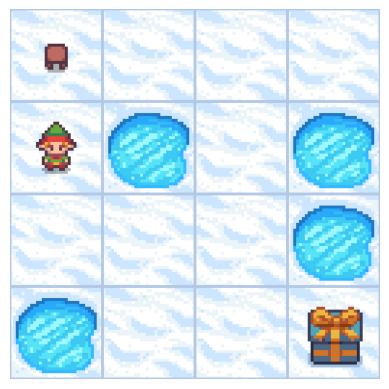

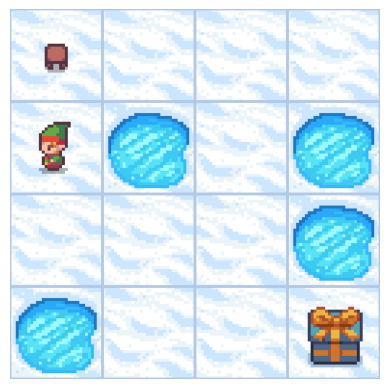

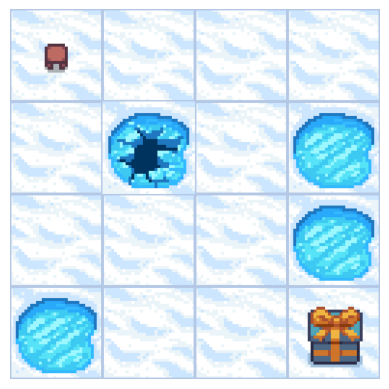

Episode: 6 Total Reward: -0.05
1/1 [==============================] - 0s 10ms/step


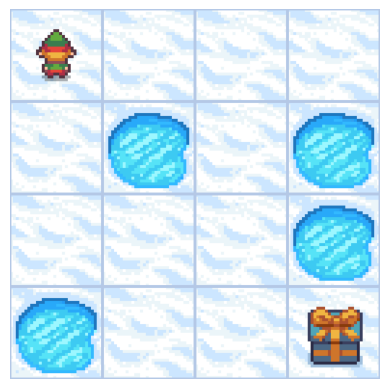

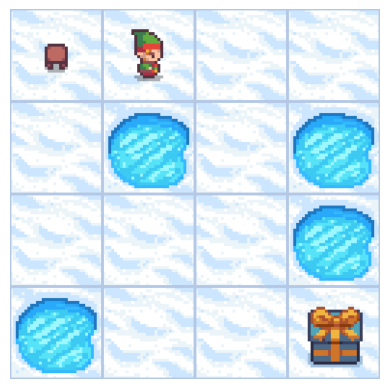

1/1 [==============================] - 0s 10ms/step


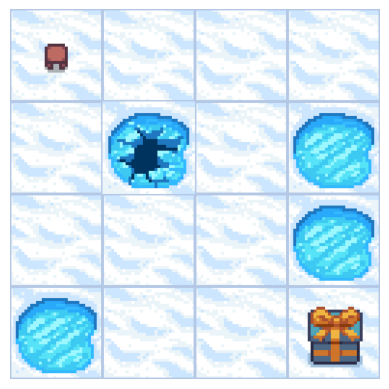

Episode: 7 Total Reward: -0.03
1/1 [==============================] - 0s 11ms/step


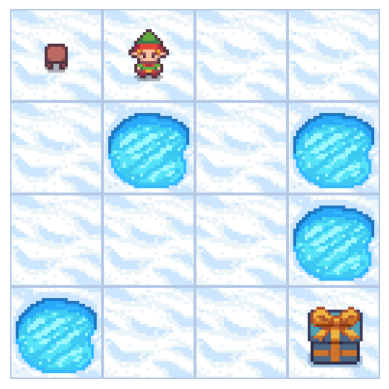

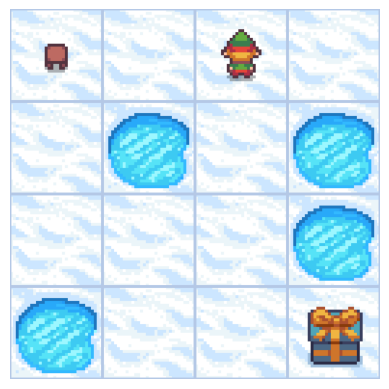

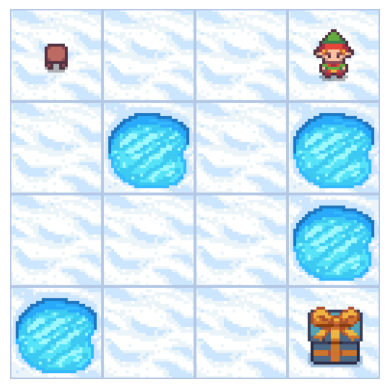

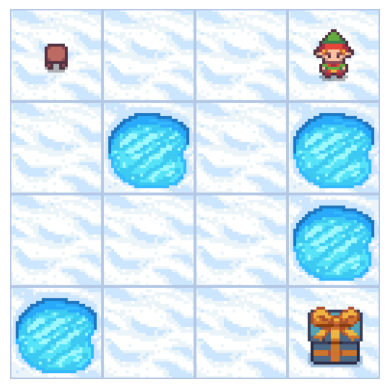

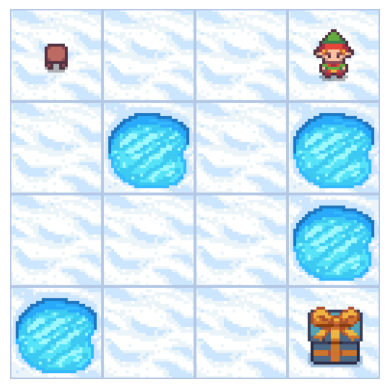

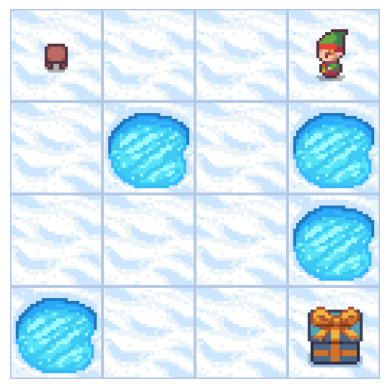

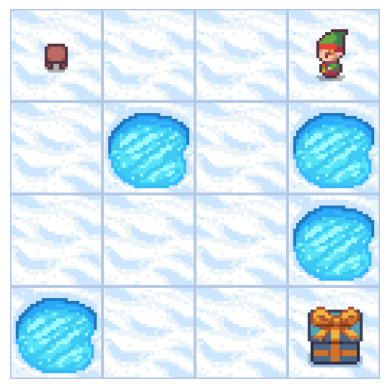

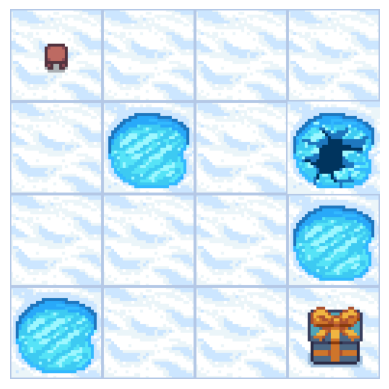

Episode: 8 Total Reward: -0.08
1/1 [==============================] - 0s 15ms/step


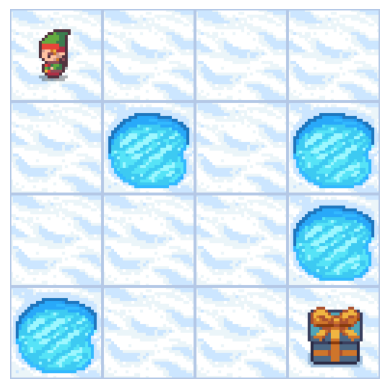

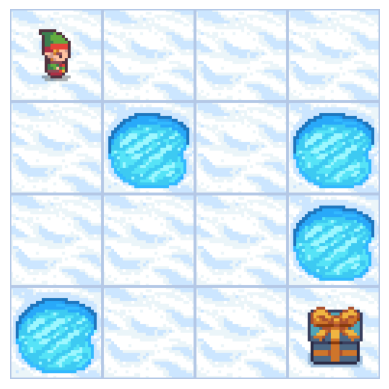

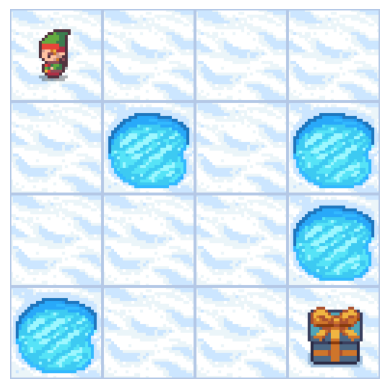

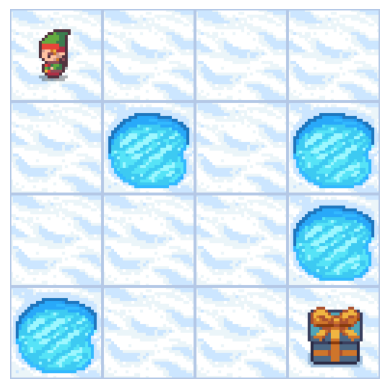

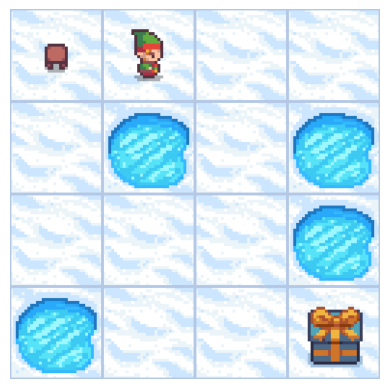

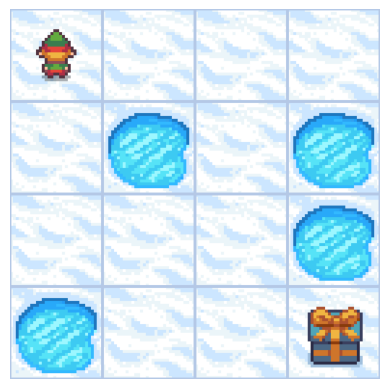

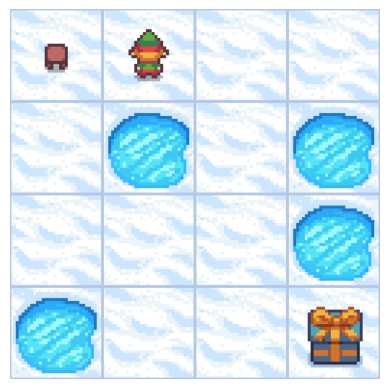

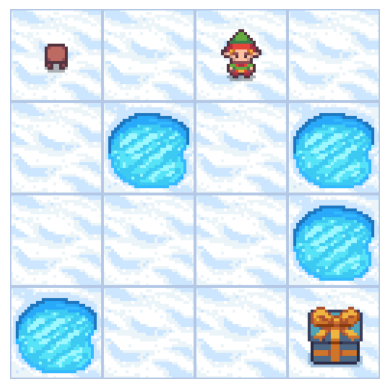

1/1 [==============================] - 0s 13ms/step


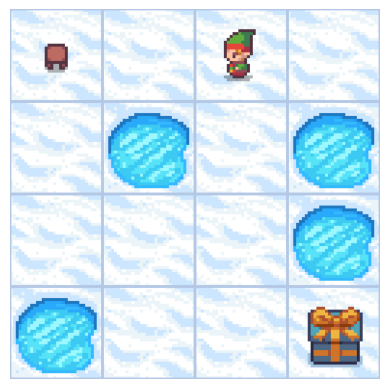

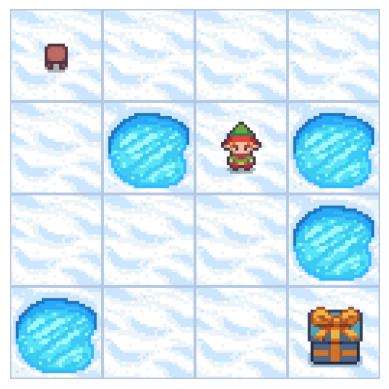

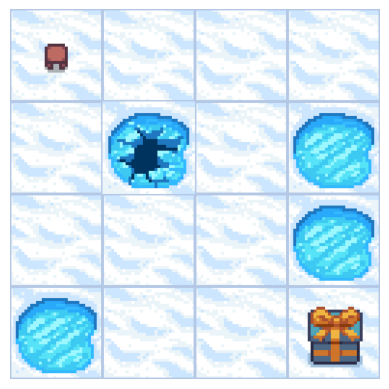

Episode: 9 Total Reward: -0.10999999999999999
1/1 [==============================] - 0s 11ms/step


In [50]:
import time

for episode in range(num_episodes):
    state = env.reset()[0]  # Extracting the integer value from the tuple
    state = np.array(state).reshape(1, -1).astype(np.float32)
    total_reward = 0
    time.sleep(1)  # Wait for a second to see the initial state

    for step in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        reward -= 0.01  # Apply the living penalty
        next_state = np.array(next_state).reshape(1, -1).astype(np.float32)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        render(env)
        time.sleep(0.5)  # Wait for half a second to see the next step

        if done:
            break

    print("Episode:", episode, "Total Reward:", total_reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    if episode % update_target_frequency == 0:
        agent.update_target_model()

    if episode % 100 == 0:
        print("Episode:", episode, "Total Reward:", total_reward)